## Causal Skeleton Discovery Using Mutual Information

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
import scipy
from ltcl.datasets.sim_dataset import SimulationDatasetTSTwoSampleNS
from ltcl.modules.srnn_ns import SRNNSyntheticNS
from ltcl.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from ltcl.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import ipdb as pdb

In [6]:
use_cuda = True
device = torch.device("cuda:0" if use_cuda else "cpu")
latent_size = 8

In [63]:
data = SimulationDatasetTSTwoSampleNS(directory = '/srv/data/ltcl/data', 
                         transition='nonlinear_gau_cins_sparse')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=12800, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [12]:
cfg = load_yaml('../ltcl/configs/toy_nonlinear_gau_ns.yaml')

In [13]:
model =  SRNNSyntheticNS.load_from_checkpoint(  checkpoint_path="/srv/data/ltcl/log/weiran/toy_nonlinear_gau_ns/lightning_logs/version_40/checkpoints/epoch=31-step=146660.ckpt",
                                                input_dim=cfg['VAE']['INPUT_DIM'],
                                                length=cfg['VAE']['LENGTH'],
                                                z_dim=cfg['VAE']['LATENT_DIM'], 
                                                lag=cfg['VAE']['LAG'],
                                                nclass=cfg['VAE']['NCLASS'],
                                                hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                                trans_prior=cfg['VAE']['TRANS_PRIOR'],
                                                bound=cfg['SPLINE']['BOUND'],
                                                count_bins=cfg['SPLINE']['BINS'],
                                                order=cfg['SPLINE']['ORDER'],
                                                beta=cfg['VAE']['BETA'],
                                                gamma=cfg['VAE']['GAMMA'],
                                                sigma=cfg['VAE']['SIGMA'],
                                                lr=cfg['VAE']['LR'],
                                                bias=cfg['VAE']['BIAS'],
                                                use_warm_start=cfg['SPLINE']['USE_WARM_START'],
                                                spline_pth=cfg['SPLINE']['PATH'],
                                                decoder_dist=cfg['VAE']['DEC']['DIST'],
                                                correlation=cfg['MCC']['CORR'])

Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow


In [64]:
for batch in train_loader:
    break
batch_size = batch['s1']['xt'].shape[0]

In [65]:
z, mu, logvar = model.forward(batch['s1'])
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,0,:].detach().cpu().numpy()
B = batch['s1']['yt'][:,0,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [4 3 2 6 0 7 1 5]
Sign Flip: [-1. -1. -1. -1. -1.  1.  1.  1.]


In [26]:
from torch.autograd.functional import jacobian
def compute_masked_jacobian(x, masks, gs, L):
    def masked_forward(mask, xxi, yy):
        inputs = torch.cat((yy*mask, xxi),dim=-1)
        return gs[i](inputs)
    batch_size, length, input_dim = x.shape
    x = x.unfold(dimension = 1, size = L+1, step = 1)
    x = torch.swapaxes(x, 2, 3)
    shape = x.shape
    x = x.reshape(-1, L+1, input_dim)
    xx, yy = x[:,-1:], x[:,:-1]
    yy = yy.reshape(-1, L*input_dim)
    pdds = [ ]
    for i in range(input_dim):
#         xxi = xx[:,:,i]
        mask = masks[i]
        # Redefine input function
        inputs = torch.cat((yy*mask, xx[:,:,i]),dim=-1)
        residual = gs[i](inputs)
        with torch.enable_grad():
            pdd = jacobian(gs[i], inputs, create_graph=True, vectorize=True)
#             pdd = jacobian(masked_forward, (mask, xxi, yy), create_graph=True, vectorize=True)
            pdds.append(pdd[2])
    return torch.stack(pdds, 0).squeeze()

In [13]:
pdds = compute_masked_jacobian(z.detach(), torch.sigmoid(model.logits).detach(), model.transition_prior.gs, 2)

> /tmp/ipykernel_2908/1649900619.py(24)compute_masked_jacobian()
     23             pdb.set_trace()
---> 24             pdds.append(pdd[2])
     25     return torch.stack(pdds, 0).squeeze()

ipdb> pdd[2]
tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [ 22.3987, -44.9978, -33.0270,  ...,  37.6301,  73.7455,  45.4146],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]],
       grad_fn=<SelectBackward>)
ipdb> pdd[2].shape
torch.Size([1, 512, 17])
ipdb> pdd[2][0:,0]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       grad_fn=<SelectBackward>)
ipdb> pdd[2][0,:,0]
tensor([ 0.0000,  0.0000, 22.3987,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         

ipdb> pdd.shape
torch.Size([512, 1, 512, 17])
ipdb> torch.diag(pdd[:,0,:,-1])
tensor([  21.7121,  366.4467,   45.4146,  291.4435,   18.5643,   18.0262,
         619.2397,   18.2988,  621.3915,  622.4697,   22.5618,  624.9552,
          18.7315,  131.1493,   18.0263,  630.3116,  620.2180,  261.6540,
         722.9315,  663.9261,  164.9251,   18.0262,  605.3912,   18.0261,
          17.3697,   17.3697,   17.3697,   17.3697,  724.1057,  660.1440,
         722.9315,   65.2541,   18.3769,  111.4160,   18.0262,  619.3035,
          18.0263,  623.4493,  435.2285,   18.0275,  663.9261,   65.2541,
          17.3697,   17.3697,   65.2541,   17.3698,   17.3697,   17.3697,
         658.8304,   18.0862,   19.5751,  262.5320,   18.0268,   20.7317,
          18.0354,  107.8331,   32.7469,   18.0770,   18.0261,   18.0261,
         623.2947,  659.1577,  555.2134,  272.6410,  294.0688,   18.0572,
          18.3178,   18.2584,   18.0792,   62.1108,   43.7159,   18.0263,
         397.8234,  662.1900,  394

BdbQuit: 

In [572]:
X_aux = np.concatenate((X,np.random.randn(25600,1)), axis=1)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_aux, Y[:,-1])
((clf.feature_importances_ >= clf.feature_importances_[-1] + 0.01)[:-1]) == ((np.concatenate((W2,W1),axis=0)[:,0])!=0)
clf.feature_importances_

RandomForestRegressor()

In [66]:
z0 = mu[:,0,:].detach().cpu().numpy()[:, col_ind]
z1 = mu[:,1,:].detach().cpu().numpy()[:, col_ind]
z2 = mu[:,2,:].detach().cpu().numpy()[:, col_ind]

In [67]:
z0 = batch['s1']['yt'][:,0,:].detach().cpu().numpy()
z1 = batch['s1']['yt'][:,1,:].detach().cpu().numpy()
z2 = batch['s1']['yt'][:,2,:].detach().cpu().numpy()

In [68]:
X = np.concatenate((z0,z1),axis=1)
X = z0
Y = z2

In [69]:
from sklearn.feature_selection import mutual_info_regression

In [103]:
accuracies = [ ]
mask = [ ]
thres = 0.030
n_neighbors = 10
for idx in range(8):
    mi = mutual_info_regression(X, Y[:,idx], n_neighbors=n_neighbors)
    mask = mask + list((mi / np.max(mi)) > thres)
    accuracies = accuracies + list(((mi / np.max(mi)) > thres) == (W2[:,idx]!=0))
print(np.mean(accuracies))

0.921875


In [54]:
accuracies = [ ]
mask = [ ]
thres = 0.085
n_neighbors = 10
for idx in range(8):
    mi = mutual_info_regression(X, Y[:,idx], n_neighbors=n_neighbors)
    mask = mask + list((mi / np.max(mi)) > thres)
#     accuracies = accuracies + list(((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0))
print(np.mean(accuracies))

nan


/home/weiran/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/weiran/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
list(((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0))

/tmp/ipykernel_19974/3627211018.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  list(((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0))


TypeError: 'bool' object is not iterable

In [40]:
((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0)

/tmp/ipykernel_19974/58818163.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  ((mi / np.max(mi)) > thres) == ((np.concatenate((W2,W1),axis=0)[:,idx])!=0)


False

In [38]:
((np.concatenate((W2,W1),axis=0)[:,idx])!=0)

array([ True, False, False, False,  True,  True, False, False,  True,
        True,  True, False, False, False,  True, False])

In [36]:
mi / np.max(mi) > thres

array([ True, False, False, False,  True,  True, False, False])

In [104]:
mask = np.array(mask).reshape(8,8)
for i in range(8):
    mask[i,i] = 1

<AxesSubplot:>

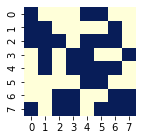

In [105]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(W2.T!=0, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

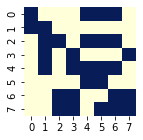

In [106]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(mask, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

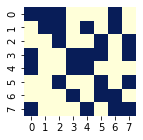

In [86]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(W1.T!=0, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

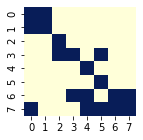

In [154]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(mask, cmap="YlGnBu", cbar=False)

In [ ]:
sns.heatmap(W1 != 0)

<AxesSubplot:>

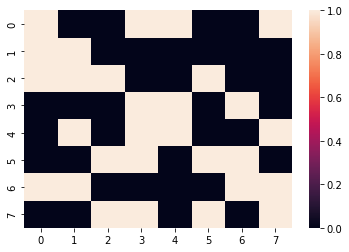

In [47]:
sns.heatmap(W1 != 0)

In [43]:
sns.heatmap(weights[:,8:]>0.1)

NameError: name 'weights' is not defined

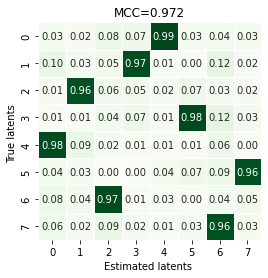

In [89]:
fig = plt.figure(figsize=(4,4))
sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
plt.xlabel("Estimated latents ") 
plt.ylabel("True latents ") 
plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());

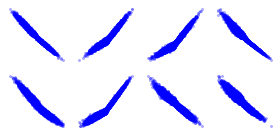

In [148]:
fig, axs = plt.subplots(2,4, figsize=(4,2))
for i in range(8):
    row = i // 4
    col = i % 4
    ax = axs[row,col]
    ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
    ax.axis('off')
#     ax.set_xlabel('Ground truth latent')
#     ax.set_ylabel('Estimated latent')
#     ax.grid('..')
fig.tight_layout()

In [78]:
W1 = np.load('/srv/data/ltcl/data/nonlinear_gau_cins_sparse/W1.npy')
W2 = np.load('/srv/data/ltcl/data/nonlinear_gau_cins_sparse/W2.npy')

In [295]:
weights = np.abs(F.sigmoid(model.logits).detach().cpu().numpy())

/home/weiran/anaconda3/envs/ltcl/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<AxesSubplot:>

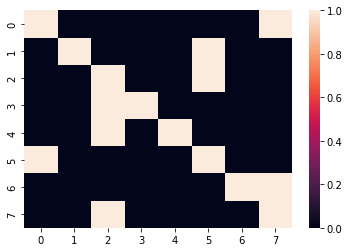

In [59]:
sns.heatmap(W1 != 0)

In [2]:
W1

NameError: name 'W1' is not defined

In [302]:
W2

array([[ 0.50156787, -0.        ,  0.51649095, -0.        ,  0.06035408,
        -0.        , -0.        ,  0.46782093],
       [ 0.47079671, -0.39963299,  0.        , -0.35943527, -0.05276724,
         0.49638188,  0.34030799, -0.15924475],
       [ 0.04290384,  0.5055123 ,  0.3679568 ,  0.        ,  0.65232091,
        -0.02017764,  0.        ,  0.04212558],
       [ 0.        , -0.34720904,  0.        ,  0.17058263,  0.08821504,
         0.13770018, -0.        , -0.        ],
       [ 0.28763306,  0.        ,  0.        ,  0.        , -0.64941761,
         0.        ,  0.        , -0.        ],
       [-0.        ,  0.48742992,  0.4686989 ,  0.        ,  0.2388617 ,
         0.45324802,  0.11994226, -0.        ],
       [ 0.        , -0.23002596, -0.        , -0.        ,  0.22471141,
        -0.        , -0.34984938,  0.        ],
       [ 0.        ,  0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        ,  0.38297653]])

<AxesSubplot:>

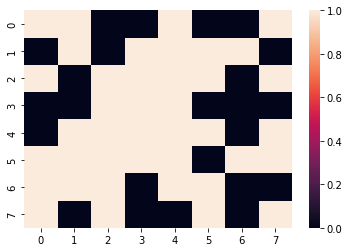

In [298]:
sns.heatmap(weights[:,8:]>0.1)

In [300]:
weights[:,:8]

array([[0.8233331 , 0.08970425, 0.42593727, 0.04783858, 0.24296457,
        0.17261018, 0.05755394, 0.18241283],
       [0.13054839, 0.04854998, 0.02348838, 0.00228652, 0.10604057,
        0.00655043, 0.7910138 , 0.03483724],
       [0.12552069, 0.41649735, 0.9732228 , 0.03145029, 0.05422412,
        0.96870095, 0.9310334 , 0.7557193 ],
       [0.03316053, 0.04665662, 0.26397365, 0.3334502 , 0.10646664,
        0.08549618, 0.15564494, 0.42340618],
       [0.11605912, 0.03629161, 0.14944774, 0.07809486, 0.32515347,
        0.07803433, 0.43854445, 0.12297837],
       [0.03559522, 0.4731839 , 0.18269105, 0.03646603, 0.06751369,
        0.6177268 , 0.88846064, 0.04196692],
       [0.04532356, 0.4676418 , 0.9225205 , 0.13536702, 0.46835965,
        0.7384365 , 0.2203281 , 0.17002684],
       [0.9331    , 0.16422059, 0.05643173, 0.08069407, 0.07562382,
        0.87256193, 0.6934192 , 0.65303624]], dtype=float32)

In [82]:
weights

array([[0.54656714, 0.48433524, 0.26725093, 0.12747212, 0.16356714,
        0.06989854, 0.05145742, 0.13741808],
       [0.02911209, 0.796344  , 0.00642451, 0.47319907, 0.21675384,
        0.9797515 , 0.2847544 , 0.07272173],
       [0.5227841 , 0.06204589, 0.68174416, 0.41993743, 0.21995212,
        0.37427014, 0.07174414, 0.5566112 ],
       [0.41810706, 0.13847053, 0.21596974, 0.31769517, 0.8180633 ,
        0.17690597, 0.11549322, 0.11461142],
       [0.1712399 , 0.9475453 , 0.6369009 , 0.8268066 , 0.5069916 ,
        0.591419  , 0.06843556, 0.77747357],
       [0.9771887 , 0.624247  , 0.41410586, 0.80532813, 0.22535357,
        0.11084127, 0.25038028, 0.6176602 ],
       [0.25273538, 0.35987946, 0.14968851, 0.09257003, 0.15158418,
        0.329446  , 0.16293703, 0.05205354],
       [0.39156476, 0.04126399, 0.6145114 , 0.04040777, 0.08973119,
        0.13764323, 0.02196096, 0.84297323]], dtype=float32)

In [155]:
import h5py

In [2]:
file = h5py.File('/srv/data/ltcl/data/physics_ball_5_s1_Ball/raw/0.h5', 'r')
states = file['states'][:]

NameError: name 'h5py' is not defined

In [258]:
from sklearn.linear_model import LinearRegression

In [263]:
X = data[:-1,0,[0,2]]
y = data[1:,0,0]

In [264]:
model = LinearRegression().fit(X,y)

In [267]:
model.coef_

array([1.  , 0.02])

In [252]:
data = states[:-1].copy()
data[:,:,2:] =states[1:,:,2:]
# data = data.reshape(99, -1)

In [241]:
data[:,0]

array([[  52.04766606,  -55.60988994,  110.23748251,   71.32994514],
       [  54.25241571,  -54.18329103,  111.03222645,   71.48829331],
       [  56.47306024,  -52.75352517,  109.88681246,   72.06224846],
       [  58.67079649,  -51.3122802 ,  103.32416392,   71.77802382],
       [  60.73727977,  -49.87671972,   92.75785454,   73.50171304],
       [  62.59243686,  -48.40668546,   76.86550114,   73.52908452],
       [  64.12974688,  -46.93610377,   55.82553193,   73.33957227],
       [  65.24625752,  -45.46931233,   29.24833919,   73.6675994 ],
       [  65.8312243 ,  -43.99596034,   -0.4153905 ,   73.83824733],
       [  65.82291649,  -42.51919539,  -29.90224985,   73.90977608],
       [  65.2248715 ,  -41.04099987,  -56.48278182,   73.96355273],
       [  64.09521586,  -39.56172881,  -75.53436748,   70.96551618],
       [  62.58452851,  -38.14241849,  -90.5345446 ,   71.38330746],
       [  60.77383762,  -36.71475234, -100.42922721,   72.04010761],
       [  58.76525307,  -35.273950

In [235]:
X = data[:-1]
Y = data[1:]

In [236]:
X.shape

(98, 12)

In [237]:
Y.shape

(98, 12)

In [238]:
for idx in range(12):
    print(mutual_info_regression(X, Y[:,idx], n_neighbors=n_neighbors))

[2.03933036 1.66582021 0.17606635 0.1305409  0.34549072 0.61683194
 0.53473987 1.12694207 0.82973132 0.85076471 0.56021714 0.78616207]
[1.6528419  2.16493571 0.45125872 0.15299615 0.49236142 0.67989572
 0.83272064 1.16535345 0.88625488 1.09815525 0.87917715 0.97103136]
[0.18836763 0.48905531 1.46744234 0.46623217 0.1452608  0.38975912
 0.42370376 0.35446559 0.30983773 0.57307301 0.50583281 0.31152715]
[0.13390578 0.19325776 0.49909257 1.24084953 0.15518046 0.07830818
 0.11574941 0.15942667 0.12637373 0.46025132 0.17298206 0.27644138]
[0.33537697 0.48299439 0.17013603 0.17780098 1.7617158  0.67010881
 0.14688181 0.28090434 0.52470673 0.35013573 0.16101618 0.56265088]
[0.68914505 0.61354154 0.37449934 0.04530295 0.44003468 1.64628507
 0.07307246 0.39532435 0.79936324 0.32070817 0.09987061 0.45922474]
[0.58488346 0.81671023 0.3736689  0.12026897 0.16049055 0.13827802
 1.67823217 0.60462345 0.24160607 0.73394203 1.59347361 0.32808072]
[1.05589532 1.20649754 0.36799881 0.17978071 0.44943519

In [178]:
mutual_info_regression(X, Y[:,1], n_neighbors=n_neighbors)

array([1.63257184, 2.16892141, 0.4268321 , 0.12656473, 0.4989086 ,
       0.67103399, 0.7571572 , 1.11839531, 0.86432415, 1.10559247,
       0.81582737, 0.94151325])

In [185]:
mutual_info_regression(X, Y[:,4], n_neighbors=n_neighbors)

array([0.33901835, 0.48992611, 0.18491545, 0.18927744, 1.76962054,
       0.65427733, 0.14499443, 0.23103447, 0.52040724, 0.35183525,
       0.17638026, 0.52083795])

In [174]:
Y.shape

(99, 12)

In [172]:
X

array([[  52.04766606,  -55.60988994,    0.        , ...,   25.04796855,
           0.        ,    0.        ],
       [  54.25241571,  -54.18329103,  110.23748251, ...,   27.68213032,
         -30.74136958,  131.70808819],
       [  56.47306024,  -52.75352517,  111.03222645, ...,   29.97476918,
         -40.5958351 ,  114.63194308],
       ...,
       [ -36.59260851,   55.41166489,   93.5372091 , ...,  -35.76700752,
        -108.59639511,  213.87440525],
       [ -34.7023794 ,   54.10125197,   94.51145529, ...,  -31.46935903,
        -104.95865769,  214.88242435],
       [ -32.77887453,   52.79438869,   96.17524358, ...,  -27.12054496,
         -99.84368321,  217.44070376]])